In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB 
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn import svm
from imblearn.combine import SMOTEENN
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import TomekLinks


In [4]:
pd.set_option('display.max_columns', None)  # Отображать все колонки


In [5]:
path_train = 'train.csv' # содержит только имя файла, без имен папок !!!
df = pd.read_csv(path_train)

In [5]:
df = df.dropna()
df = df.drop_duplicates()

In [6]:
df['qual'] = np.where(df['quality'] >= 7, 1, 0)
df = df.drop('quality', axis=1)
df.rename(columns={'qual': 'quality'}, inplace=True)

In [7]:
# df_features = df.copy()

# df_features['acidity_ratio'] = df_features['fixed acidity'] / (df_features['volatile acidity'] + 1e-5)
# df_features['total_acidity'] = df_features['fixed acidity'] + df_features['volatile acidity']
# df_features['sulfite_ratio'] = df_features['free sulfur dioxide'] / (df_features['total sulfur dioxide'] + 1e-5)
# df_features['density_alcohol_interaction'] = df_features['density'] * df_features['alcohol']
# df_features['pH_acidity_difference'] = df_features['pH'] - df_features['fixed acidity']
# df_features['high_alcohol'] = (df_features['alcohol'] > 12).astype(int)

In [75]:
X = df.drop('quality', axis=1)
y = df['quality']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## Модели без преднастройки + SVM

In [48]:
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       264
           1       0.41      0.76      0.53        41

    accuracy                           0.82       305
   macro avg       0.68      0.79      0.71       305
weighted avg       0.88      0.82      0.84       305



позиция порога 0.5 -  37
в позиции 12 для ROC
fpr:     0.064  tpr:        0.195  thresholds:,0.872
recall:  0.195  precision:, 0.320  thresholds:,0.872


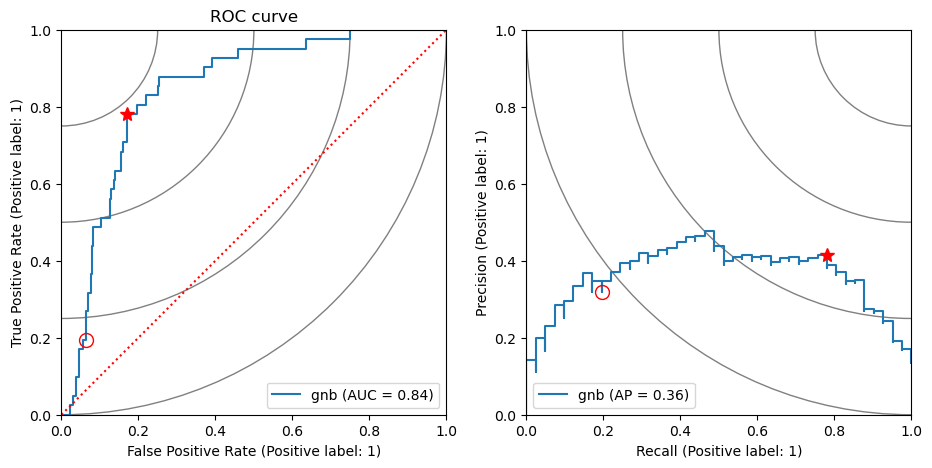

In [50]:
# фунция нахождения ближайшего индекса в упорядоченном списке
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
#######################################################
pos = 12# зададим порог (2) (21, 61)
point = find_nearest(thresholds,0.5) # найдем позицию порога вероятности 0.5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! звездочка
#######################################################
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((0, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((0, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((0, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((0, 1), 1, color='gray',fill=False)
ax1.add_patch(circle0)
ax1.add_patch(circle1)
ax1.add_patch(circle2)
ax1.add_patch(circle3)
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

precision, recall, thresholds_pr = precision_recall_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)  # найдем позицию порога вероятности 0.5
pos_pr = find_nearest(thresholds_pr,thresholds[pos]) # найдем позицию порога для thresholds в позиции pos

ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((1, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((1, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((1, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((1, 1), 1, color='gray',fill=False)
ax2.add_patch(circle0)
ax2.add_patch(circle1)
ax2.add_patch(circle2)
ax2.add_patch(circle3)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))

print( 'позиция порога 0.5 - ', point)
print( 'в позиции', pos, 'для ROC')
print( f'fpr:     {fpr[pos]:.3f}',       f' tpr:        {tpr[pos]:.3f}',          f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')


In [52]:
gnb = LogisticRegression(penalty=None, max_iter=1000).fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       264
           1       0.52      0.34      0.41        41

    accuracy                           0.87       305
   macro avg       0.71      0.65      0.67       305
weighted avg       0.85      0.87      0.86       305



позиция порога 0.5 -  14
в позиции 9 для ROC
fpr:     0.038  tpr:        0.244  thresholds:,0.548
recall:  0.244  precision:, 0.500  thresholds:,0.548


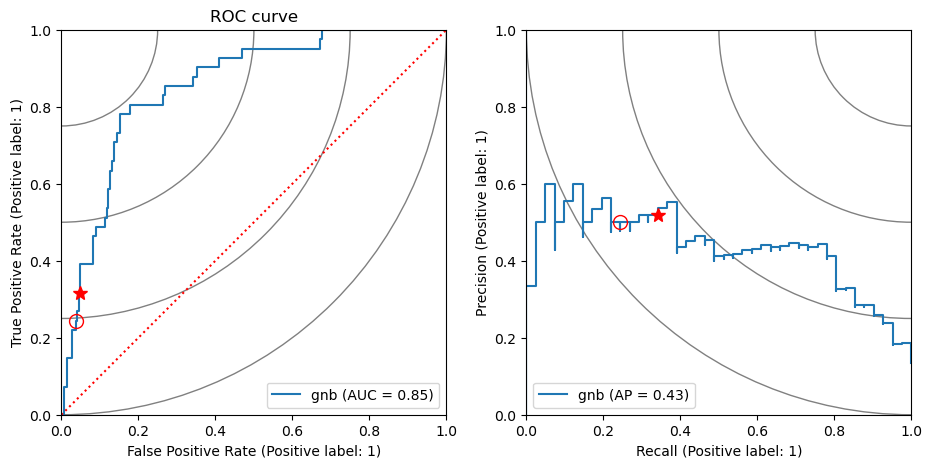

In [54]:
# фунция нахождения ближайшего индекса в упорядоченном списке
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
#######################################################
pos = 9# зададим порог (2) (21, 61)
point = find_nearest(thresholds,0.5) # найдем позицию порога вероятности 0.5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! звездочка
#######################################################
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((0, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((0, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((0, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((0, 1), 1, color='gray',fill=False)
ax1.add_patch(circle0)
ax1.add_patch(circle1)
ax1.add_patch(circle2)
ax1.add_patch(circle3)
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

precision, recall, thresholds_pr = precision_recall_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)  # найдем позицию порога вероятности 0.5
pos_pr = find_nearest(thresholds_pr,thresholds[pos]) # найдем позицию порога для thresholds в позиции pos

ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((1, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((1, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((1, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((1, 1), 1, color='gray',fill=False)
ax2.add_patch(circle0)
ax2.add_patch(circle1)
ax2.add_patch(circle2)
ax2.add_patch(circle3)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))

print( 'позиция порога 0.5 - ', point)
print( 'в позиции', pos, 'для ROC')
print( f'fpr:     {fpr[pos]:.3f}',       f' tpr:        {tpr[pos]:.3f}',          f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')


In [56]:
# pipe = Pipeline([('preprocessing', StandardScaler()), 
#                  ('classifier', svm.SVC(probability=True))])  # Включаем probability=True

# # Параметры для поиска по сетке
# C = np.linspace(0.0001, 0.001, 5) 
# gamma = np.linspace(0.0001, 0.001, 5) 

# # C=np.array([0.01,0.1,1,10,100,10**3,10**4, 10**5])
# # gamma=[0.01,0.1,1,5,10,100]

# cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=5)

# param_grid = [
#     {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler()], 
#      'classifier': [svm.SVC(probability=True, class_weight='balanced')],  # Вероятности включены
#      'classifier__C': C,
#      'classifier__gamma': gamma
#     }
# ]

# # Настройка GridSearchCV для расчета roc_auc
# grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1, scoring='roc_auc')  # Используем roc_auc

# # Обучение
# grid.fit(X_train, y_train)

# # Преобразование результатов в таблицу
# gridresults = pd.DataFrame(grid.cv_results_) # вывод лучших результатов
# pv_table=gridresults.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='mean_test_score')
# pv_table_std=gridresults.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='std_test_score')
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# sns.heatmap(pv_table, annot=True, linewidths=.5, ax=ax1)
# sns.heatmap(pv_table_std, annot=True, linewidths=.5, ax=ax2);


In [58]:
# print("Лучшие параметры:", grid.best_params_)

In [60]:

# svm_pipeline = make_pipeline(
#     RobustScaler(),
#     SVC(
#         kernel='rbf',
#         class_weight='balanced',
#         C=0.001,  # Параметр C
#         gamma=0.001,  # Параметр gamma
#         random_state=42
#     )
# )

# # Обучаем модель
# svm_pipeline.fit(X_train, y_train)

# # Предсказания
# y_pred = svm_pipeline.predict(X_test)

# # Отчёт по классификации
# print(classification_report(y_test, y_pred))


## Логистическая регрессия

In [79]:
pipe = Pipeline([
    ('preprocessing', MinMaxScaler()), 
    ('clf', LogisticRegression())
])

cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=4, random_state=42)
# score = make_scorer(precision_score, pos_label=1)

scaling = [MinMaxScaler(), StandardScaler(), RobustScaler()]

param_grid = [
    {'preprocessing': scaling,
     'clf__penalty': ['l2', 'l1'], 
     'clf__solver': ['saga', 'liblinear'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [6000],
     'clf__random_state': [42]},

    {'preprocessing': scaling,
     'clf__penalty': ['l2', None],  
     'clf__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [6000],
     'clf__random_state': [42]}
]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, scoring='roc_auc')#score)
grid.fit(X_train, y_train)

print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)  # вывод лучших результатов
display(gridresults.sort_values(["rank_test_score"]).T)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter 

Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.858227

Правильность для наилучшей модели на тестовом наборе: 0.886086



,9,5,17,20,8,14,23,2,6,11,4,10,22,19,13,16,35,34,33,32,31,30,29,26,24,28,25,7,27,3,1,12,18,0,21,15
mean_fit_time,0.009183,0.006115,0.007812,0.007814,0.032245,0.015623,0.019515,0.03126,0.011716,0.003903,0.001244,0.003915,0.003919,0.003906,0.003893,0.003906,0.019865,0.015624,0.007803,0.011197,0.003919,0.0,0.011705,0.003919,0.007812,0.005423,0.008039,0.574517,0.005948,0.007813,0.333305,0.004605,0.007824,0.006137,0.007796,0.003907
std_fit_time,0.010554,0.004353,0.007812,0.007814,0.015404,0.000001,0.00674,0.000026,0.006764,0.006761,0.002155,0.006782,0.006788,0.006765,0.006743,0.006765,0.006561,0.000001,0.009687,0.006516,0.006788,0.0,0.006758,0.006788,0.007812,0.00639,0.008047,0.043955,0.007509,0.007813,0.188291,0.007976,0.007824,0.000554,0.007796,0.006766
mean_score_time,0.004257,0.00942,0.003906,0.003906,0.0,0.0,0.0,0.0,0.0,0.007814,0.0,0.0,0.003905,0.0,0.003907,0.0,0.003906,0.0,0.000534,0.000526,0.007813,0.00397,0.0,0.011717,0.003906,0.004169,0.00199,0.006907,0.00108,0.0,0.0,0.0,0.003895,0.002904,0.003918,0.003906
std_score_time,0.006593,0.006632,0.006765,0.006765,0.0,0.0,0.0,0.0,0.0,0.007814,0.0,0.0,0.006764,0.0,0.006766,0.0,0.006766,0.0,0.000926,0.000911,0.007813,0.006876,0.0,0.006765,0.006765,0.006656,0.002433,0.005614,0.00108,0.0,0.0,0.0,0.006745,0.003068,0.006786,0.006765
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_clf__max_iter,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000
param_clf__penalty,l1,l2,l2,l2,l1,l2,l2,l2,l1,l1,l2,l1,l2,l2,l2,l2,None,None,None,None,None,None,None,None,None,None,None,l1,None,l2,l2,l2,l2,l2,l2,l2
param_clf__random_state,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
param_clf__solver,liblinear,liblinear,newton-cg,newton-cholesky,saga,lbfgs,sag,saga,saga,liblinear,liblinear,liblinear,sag,newton-cholesky,lbfgs,newton-cg,sag,sag,sag,newton-cholesky,newton-cholesky,newton-cholesky,newton-cg,lbfgs,lbfgs,newton-cg,lbfgs,saga,newton-cg,liblinear,saga,lbfgs,newton-cholesky,saga,sag,newton-cg
param_preprocessing,MinMaxScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),RobustScaler(),RobustScaler(),MinMaxScaler(),StandardScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler()


In [69]:
# gridresults.sort_values(["rank_test_score"]).T[22].loc['params']
print("Лучшие параметры:", grid.best_params_)

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__max_iter': 6000, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'saga', 'preprocessing': StandardScaler()}


In [81]:
gnb = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=6000, random_state=42))
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87       264
           1       0.38      0.85      0.52        41

    accuracy                           0.79       305
   macro avg       0.67      0.82      0.69       305
weighted avg       0.89      0.79      0.82       305



позиция порога 0.5 -  37
в позиции 6 для ROC
fpr:     0.019  tpr:        0.244  thresholds:,0.881
recall:  0.244  precision:, 0.667  thresholds:,0.881


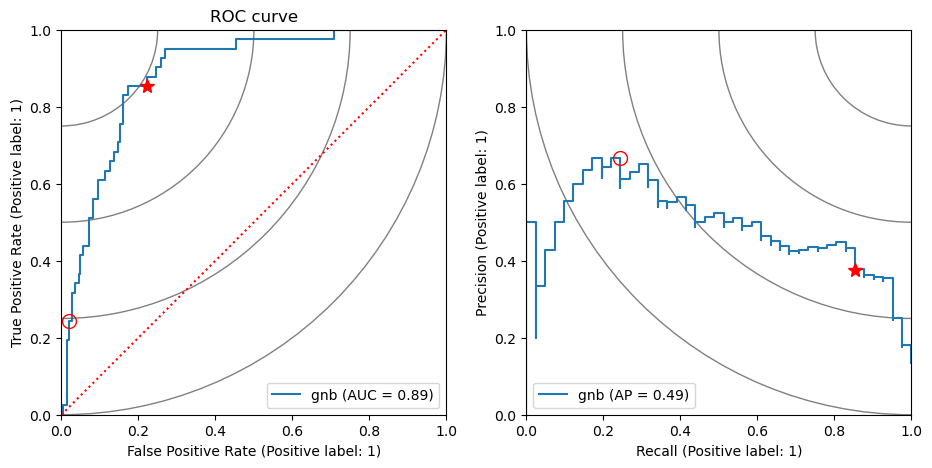

In [85]:
# фунция нахождения ближайшего индекса в упорядоченном списке
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
#######################################################
pos = 6# зададим порог (2) (21, 61)
point = find_nearest(thresholds,0.5) # найдем позицию порога вероятности 0.5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! звездочка
#######################################################
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((0, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((0, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((0, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((0, 1), 1, color='gray',fill=False)
ax1.add_patch(circle0)
ax1.add_patch(circle1)
ax1.add_patch(circle2)
ax1.add_patch(circle3)
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

precision, recall, thresholds_pr = precision_recall_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)  # найдем позицию порога вероятности 0.5
pos_pr = find_nearest(thresholds_pr,thresholds[pos]) # найдем позицию порога для thresholds в позиции pos

ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((1, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((1, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((1, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((1, 1), 1, color='gray',fill=False)
ax2.add_patch(circle0)
ax2.add_patch(circle1)
ax2.add_patch(circle2)
ax2.add_patch(circle3)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))

print( 'позиция порога 0.5 - ', point)
print( 'в позиции', pos, 'для ROC')
print( f'fpr:     {fpr[pos]:.3f}',       f' tpr:        {tpr[pos]:.3f}',          f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')


In [23]:
# X_full = np.vstack([X_train, X_test])
# y_full = np.hstack([y_train, y_test])

# best_model = grid.best_estimator_
# cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
# cv_scores = cross_val_score(best_model, X_full, y_full, cv=cv, scoring='roc_auc')

# print(f"Оценки ROC AUC на всех фолдах: {cv_scores}")
# print(f"Средняя оценка ROC AUC на фолдах: {cv_scores.mean():.6f}")


In [24]:
best_model = grid.best_estimator_

# Коэффициенты признаков
coefficients = best_model.named_steps['clf'].coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Если у вас названия признаков находятся в X_train
    'Importance': coefficients
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

                 Feature  Importance
10               alcohol    1.133146
9              sulphates    0.577314
0          fixed acidity    0.577116
3         residual sugar    0.284851
5    free sulfur dioxide    0.120104
8                     pH    0.000000
2            citric acid   -0.065153
7                density   -0.340240
6   total sulfur dioxide   -0.374293
4              chlorides   -0.663847
1       volatile acidity   -0.667819


## Метод ближайших соседей

In [26]:
# cv = StratifiedKFold(n_splits=5, shuffle=True)
# score = make_scorer(precision_score, pos_label=1)

# pipe = Pipeline([('preprocessing', MinMaxScaler()), 
#                  ('classifier', KNeighborsClassifier())])

# # n_neighbors=[40]
# # p=[6]

# n_neighbors=[40]
# p=[6]
# weights=['uniform','distance'] #штрафы на дистанции

# param_grid =[
#     {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler()],
#      'classifier': [KNeighborsClassifier()],
#      'classifier__n_neighbors': n_neighbors,
#      'classifier__p': p,
#      'classifier__weights': weights
#      }
# ]

# grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1, scoring=score)
# grid.fit(X_train,y_train)

# print("Средняя правильность для наилучшей модели кроссвалидации на \
#                 валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
# print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
# gridresults = pd.DataFrame(grid.cv_results_) # вывод лучших результатов
# display(gridresults.sort_values(["rank_test_score"]).T)

## SMOTE и ADASYN

In [28]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [29]:
pipe = Pipeline([
    ('preprocessing', MinMaxScaler()), 
    ('clf', LogisticRegression())
])

cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=3, random_state=42)
# score = make_scorer(precision_score, pos_label=1)

scaling = [MinMaxScaler(), StandardScaler(), RobustScaler()]

param_grid = [
    {'preprocessing': scaling,
     'clf__penalty': ['l2', 'l1'], 
     'clf__solver': ['saga', 'liblinear'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [5000],
     'clf__random_state': [42]},

    {'preprocessing': scaling,
     'clf__penalty': ['l2', None],  
     'clf__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [5000],
     'clf__random_state': [42]}
]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, scoring='roc_auc')#score)
grid.fit(X_resampled, y_resampled)

print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)  # вывод лучших результатов
display(gridresults.sort_values(["rank_test_score"]).T)


Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.897652

Правильность для наилучшей модели на тестовом наборе: 0.876486



,12,0,21,18,15,3,6,9,7,10,4,13,1,19,22,16,33,30,32,28,31,34,29,27,8,25,24,35,26,11,17,14,20,5,23,2
mean_fit_time,0.006939,0.010434,0.008017,0.006514,0.006019,0.005223,0.010417,0.018753,0.015626,0.005212,0.0,0.001136,0.0,0.005307,0.008713,0.00809,0.009391,0.001165,0.005208,0.007613,0.015622,0.011238,0.008121,0.0111,0.039963,0.012292,0.013066,0.031849,0.013098,0.008837,0.008189,0.005397,0.010487,0.010413,0.025299,0.031538
std_fit_time,0.006499,0.007378,0.006387,0.001098,0.000174,0.007387,0.007366,0.002597,0.000004,0.007371,0.0,0.001606,0.0,0.000972,0.002569,0.002707,0.006758,0.001648,0.007365,0.006385,0.000002,0.008047,0.002878,0.003923,0.009182,0.004604,0.005045,0.000547,0.003572,0.007551,0.002777,0.005063,0.003635,0.007363,0.006808,0.000451
mean_score_time,0.0,0.005212,0.006603,0.003428,0.0,0.002664,0.005207,0.0,0.0,0.005204,0.005207,0.006879,0.010412,0.003879,0.002026,0.006152,0.0,0.001992,0.005208,0.002683,0.0,0.0,0.006025,0.001343,0.005684,0.000284,0.0,0.002015,0.0,0.000037,0.00204,0.007846,0.004996,0.0,0.004106,0.002199
std_score_time,0.0,0.007371,0.006831,0.002427,0.0,0.003767,0.007364,0.0,0.0,0.007359,0.007364,0.006513,0.007362,0.002781,0.002865,0.00055,0.0,0.002817,0.007365,0.003794,0.0,0.0,0.003996,0.0019,0.004026,0.000401,0.0,0.002849,0.0,0.000052,0.002885,0.00624,0.00366,0.0,0.002907,0.00311
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_clf__max_iter,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
param_clf__penalty,l2,l2,l2,l2,l2,l2,l1,l1,l1,l1,l2,l2,l2,l2,l2,l2,None,None,None,None,None,None,None,None,l1,None,None,None,None,l1,l2,l2,l2,l2,l2,l2
param_clf__random_state,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
param_clf__solver,lbfgs,saga,sag,newton-cholesky,newton-cg,liblinear,saga,liblinear,saga,liblinear,liblinear,lbfgs,saga,newton-cholesky,sag,newton-cg,sag,newton-cholesky,newton-cholesky,newton-cg,newton-cholesky,sag,newton-cg,newton-cg,saga,lbfgs,lbfgs,sag,lbfgs,liblinear,newton-cg,lbfgs,newton-cholesky,liblinear,sag,saga
param_preprocessing,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler()


In [30]:
print("Лучшие параметры:", grid.best_params_)

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__max_iter': 5000, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'lbfgs', 'preprocessing': MinMaxScaler()}


In [31]:
gnb = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l1', solver='saga', class_weight='balanced', max_iter=5000, random_state=42))
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       289
           1       0.36      0.85      0.51        46

    accuracy                           0.78       335
   macro avg       0.67      0.81      0.68       335
weighted avg       0.89      0.78      0.81       335



позиция порога 0.5 -  43
в позиции 8 для ROC
fpr:     0.021  tpr:        0.196  thresholds:,0.908
recall:  0.196  precision:, 0.600  thresholds:,0.908


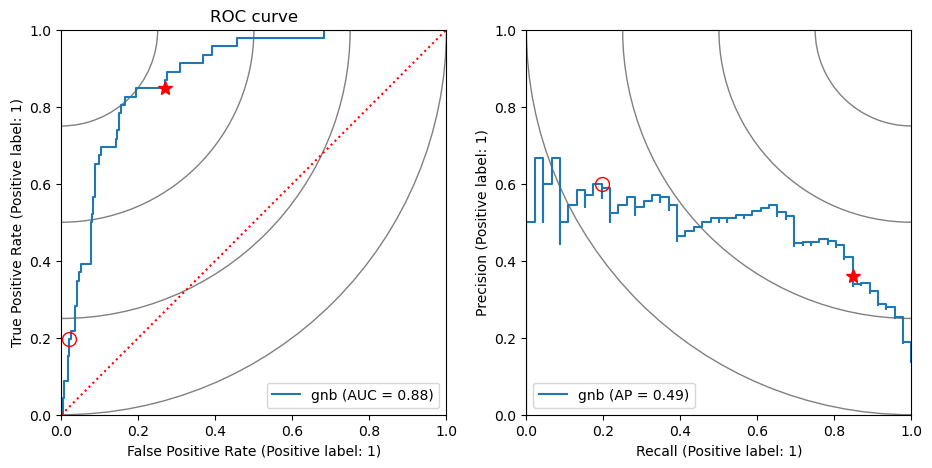

In [32]:
# фунция нахождения ближайшего индекса в упорядоченном списке
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
#######################################################
pos = 8  # зададим порог (2) (21, 61)
point = find_nearest(thresholds,0.5) # найдем позицию порога вероятности 0.5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! звездочка
#######################################################
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((0, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((0, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((0, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((0, 1), 1, color='gray',fill=False)
ax1.add_patch(circle0)
ax1.add_patch(circle1)
ax1.add_patch(circle2)
ax1.add_patch(circle3)
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

precision, recall, thresholds_pr = precision_recall_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)  # найдем позицию порога вероятности 0.5
pos_pr = find_nearest(thresholds_pr,thresholds[pos]) # найдем позицию порога для thresholds в позиции pos

ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((1, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((1, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((1, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((1, 1), 1, color='gray',fill=False)
ax2.add_patch(circle0)
ax2.add_patch(circle1)
ax2.add_patch(circle2)
ax2.add_patch(circle3)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))

print( 'позиция порога 0.5 - ', point)
print( 'в позиции', pos, 'для ROC')
print( f'fpr:     {fpr[pos]:.3f}',       f' tpr:        {tpr[pos]:.3f}',          f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')


In [33]:
adasyn = ADASYN(random_state=42)

# Преобразуем выборку
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [34]:
pipe = Pipeline([
    ('preprocessing', MinMaxScaler()), 
    ('clf', LogisticRegression())
])

cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=4, random_state=42)
# score = make_scorer(precision_score, pos_label=1)

scaling = [MinMaxScaler(), StandardScaler(), RobustScaler()]

param_grid = [
    {'preprocessing': scaling,
     'clf__penalty': ['l2', 'l1'], 
     'clf__solver': ['saga', 'liblinear'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [5000],
     'clf__random_state': [42]},

    {'preprocessing': scaling,
     'clf__penalty': ['l2', None],  
     'clf__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [5000],
     'clf__random_state': [42]}
]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, scoring='roc_auc')#score)
grid.fit(X_resampled, y_resampled)

print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)  # вывод лучших результатов
display(gridresults.sort_values(["rank_test_score"]).T)


Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.890732

Правильность для наилучшей модели на тестовом наборе: 0.878818



,6,9,7,10,12,0,15,21,18,1,11,19,8,13,22,4,16,26,25,3,27,28,30,32,31,35,34,33,29,24,14,2,23,5,20,17
mean_fit_time,0.022433,0.007334,0.013649,0.006053,0.003484,0.009614,0.003906,0.013747,0.00781,0.011809,0.006314,0.011717,0.041068,0.005596,0.012375,0.005012,0.001631,0.005999,0.0077,0.005332,0.007811,0.005307,0.007733,0.005844,0.011729,0.018792,0.00781,0.001481,0.005914,0.013914,0.010323,0.037469,0.019544,0.012576,0.009977,0.003072
std_fit_time,0.013641,0.005579,0.002681,0.006557,0.003555,0.006545,0.006765,0.003252,0.00781,0.008351,0.007853,0.006765,0.009849,0.003349,0.003923,0.003075,0.002824,0.003464,0.000807,0.006391,0.007811,0.006382,0.006083,0.006458,0.006772,0.003523,0.00781,0.002564,0.006495,0.003313,0.006712,0.006044,0.006755,0.006023,0.006034,0.005321
mean_score_time,0.002994,0.003921,0.001536,0.006986,0.003906,0.003908,0.0,0.001612,0.003894,0.0,0.005455,0.0,0.00334,0.007138,0.0,0.00151,0.005948,0.0,0.004062,0.000142,0.0,0.005456,0.001521,0.005416,0.0,0.002155,0.0,0.011717,0.0,0.003892,0.0,0.000425,0.0,0.00129,0.005874,0.003814
std_score_time,0.002994,0.006791,0.002558,0.007085,0.006765,0.006768,0.0,0.002792,0.006745,0.0,0.006418,0.0,0.003516,0.005999,0.0,0.002615,0.006506,0.0,0.004063,0.000246,0.0,0.006392,0.002635,0.006388,0.0,0.003732,0.0,0.006765,0.0,0.006742,0.0,0.000737,0.0,0.002234,0.005003,0.006605
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_clf__max_iter,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000,5000
param_clf__penalty,l1,l1,l1,l1,l2,l2,l2,l2,l2,l2,l1,l2,l1,l2,l2,l2,l2,None,None,l2,None,None,None,None,None,None,None,None,None,None,l2,l2,l2,l2,l2,l2
param_clf__random_state,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
param_clf__solver,saga,liblinear,saga,liblinear,lbfgs,saga,newton-cg,sag,newton-cholesky,saga,liblinear,newton-cholesky,saga,lbfgs,sag,liblinear,newton-cg,lbfgs,lbfgs,liblinear,newton-cg,newton-cg,newton-cholesky,newton-cholesky,newton-cholesky,sag,sag,sag,newton-cg,lbfgs,lbfgs,saga,sag,liblinear,newton-cholesky,newton-cg
param_preprocessing,MinMaxScaler(),MinMaxScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),StandardScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),MinMaxScaler(),RobustScaler(),MinMaxScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler()


## Простое случайное удаление

In [36]:
y_train.value_counts()

quality
0    588
1     92
Name: count, dtype: int64

In [37]:
y_test.value_counts()

quality
0    289
1     46
Name: count, dtype: int64

In [38]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.columns = list(X_train.columns) + ['quality']  # Присваиваем колонке меток название 'quality'

n_remove = 300  # Задаем количество удаляемых строк

class_0 = df_train[df_train['quality'] == 0]
class_1 = df_train[df_train['quality'] == 1]

class_0_undersampled = class_0.sample(n=len(class_0) - n_remove)

df_balanced = pd.concat([class_0_undersampled, class_1], axis=0)

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_balanced = df_balanced.drop(columns=['quality'])
y_train_balanced = df_balanced['quality']

In [39]:
y_train_balanced.value_counts()

quality
0    288
1     92
Name: count, dtype: int64

In [40]:
gnb = LogisticRegression(penalty=None, max_iter=1000).fit(X_train_balanced, y_train_balanced)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       289
           1       0.44      0.70      0.54        46

    accuracy                           0.84       335
   macro avg       0.70      0.78      0.72       335
weighted avg       0.88      0.84      0.85       335



In [41]:
# pipe = Pipeline([
#     ('preprocessing', MinMaxScaler()), 
#     ('clf', LogisticRegression())
# ])

# cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=4, random_state=42)
# score = make_scorer(precision_score, pos_label=1)

# scaling = [MinMaxScaler(), StandardScaler(), RobustScaler()]

# param_grid = [
#     {'preprocessing': scaling,
#      'clf__penalty': ['l2', 'l1'], 
#      'clf__solver': ['saga', 'liblinear'],
#      'clf__class_weight': ['balanced'],
#      'clf__max_iter': [5000],
#      'clf__random_state': [42]},

#     {'preprocessing': scaling,
#      'clf__penalty': ['l2', None],  
#      'clf__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
#      'clf__class_weight': ['balanced'],
#      'clf__max_iter': [5000],
#      'clf__random_state': [42]}
# ]

# grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, scoring=score)
# grid.fit(X_train_balanced, y_train_balanced)

# print("Средняя правильность для наилучшей модели кроссвалидации на \
#                 валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
# print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
# gridresults = pd.DataFrame(grid.cv_results_)  # вывод лучших результатов
# display(gridresults.sort_values(["rank_test_score"]).T)


In [42]:
gnb = GaussianNB().fit(X_train_balanced, y_train_balanced)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87       289
           1       0.38      0.85      0.53        46

    accuracy                           0.79       335
   macro avg       0.68      0.81      0.70       335
weighted avg       0.89      0.79      0.82       335



In [43]:
knn = KNeighborsClassifier(n_neighbors=3) 
knn.fit(X_train_balanced, y_train_balanced)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       289
           1       0.30      0.43      0.35        46

    accuracy                           0.78       335
   macro avg       0.60      0.64      0.61       335
weighted avg       0.82      0.78      0.80       335



In [51]:
# pipe = Pipeline([('preprocessing', StandardScaler()), 
#                  ('classifier', svm.SVC(probability=True))])  # Включаем probability=True

# # Параметры для поиска по сетке
# # C = np.linspace(0.0001, 0.001, 5) 
# # gamma = np.linspace(0.0001, 0.001, 5) 

# C=np.array([0.01,0.1,1,10,100,10**3,10**4, 10**5])
# gamma=[0.01,0.1,1,5,10,100]
# kernels = ['linear']  # Ядра для SVC
# # 'linear', 'poly', 'rbf', 'sigmoid'

# cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=3)

# param_grid = [
#     {'preprocessing': [StandardScaler()], #MinMaxScaler(), RobustScaler()], 
#      'classifier': [svm.SVC(probability=True, class_weight='balanced')],  # Вероятности включены
#      'classifier__C': C,
#      'classifier__gamma': gamma,
#      'classifier__kernel': kernels  # Ядра для проверки
#     }
# ]

# # Настройка GridSearchCV для расчета roc_auc
# grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, n_jobs=-1, scoring='roc_auc')  # Используем roc_auc

# # Обучение
# grid.fit(X_train, y_train)

# # Преобразование результатов в таблицу
# gridresults = pd.DataFrame(grid.cv_results_) # вывод лучших результатов
# pv_table=gridresults.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='mean_test_score')
# pv_table_std=gridresults.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='std_test_score')
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# sns.heatmap(pv_table, annot=True, linewidths=.5, ax=ax1)
# sns.heatmap(pv_table_std, annot=True, linewidths=.5, ax=ax2);


## Cluster Centroids

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [84]:
X_majority = X[y == 0]  # Данные класса большинства
X_minority = X[y == 1]  # Данные класса меньшинства

n_clusters = len(X_minority)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_majority)

X_majority_resampled = kmeans.cluster_centers_

X_resampled = np.vstack((X_minority, X_majority_resampled))
y_resampled = np.hstack((np.ones(len(X_minority)), np.zeros(len(X_majority_resampled))))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [106]:
columns = X.columns  # Если исходные данные X были DataFrame, иначе создайте список имен колонок
X_train_resampled_df = pd.DataFrame(X_resampled, columns=columns)
y_train_resampled_df = pd.DataFrame(y_resampled, columns=['quality'])  # Или можно использовать pd.Series

train_resampled_df = pd.concat([X_train_resampled_df, y_train_resampled_df], axis=1)

In [110]:
X_resampled = train_resampled_df.drop('quality', axis=1)
y_resampled = train_resampled_df['quality']

## Edited Nearest Neighbors (ENN)

In [145]:
enn = EditedNearestNeighbours(n_neighbors=3)
X_resampled, y_resampled = enn.fit_resample(X_train, y_train)

## TomekLinks


In [175]:
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)

In [183]:
pipe = Pipeline([
    ('preprocessing', MinMaxScaler()), 
    ('clf', LogisticRegression())
])

cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=4, random_state=42)
# score = make_scorer(precision_score, pos_label=1)

scaling = [MinMaxScaler(), StandardScaler(), RobustScaler()]

param_grid = [
    {'preprocessing': scaling,
     'clf__penalty': ['l2', 'l1'], 
     'clf__solver': ['saga', 'liblinear'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [6000],
     'clf__random_state': [42]},

    {'preprocessing': scaling,
     'clf__penalty': ['l2', None],  
     'clf__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [6000],
     'clf__random_state': [42]}
]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, scoring='roc_auc')#score)
grid.fit(X_resampled, y_resampled)

print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)  # вывод лучших результатов
display(gridresults.sort_values(["rank_test_score"]).T)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.882846

Правильность для наилучшей модели на тестовом наборе: 0.873522



,18,0,21,12,15,3,8,6,11,2,23,20,17,5,14,7,10,1,4,13,19,22,16,9,24,26,35,25,28,27,29,30,31,32,33,34
mean_fit_time,0.006085,0.006631,0.007056,0.007113,0.009005,0.008445,0.027219,0.013215,0.008021,0.036278,0.019544,0.007615,0.010557,0.006121,0.013367,0.130319,0.006067,0.128336,0.007452,0.009624,0.006234,0.007974,0.007538,0.007773,0.015622,0.016727,0.019469,0.003905,0.006512,0.009791,0.011877,0.006734,0.006037,0.007426,0.012082,0.009971
std_fit_time,0.000036,0.001358,0.00148,0.003737,0.004115,0.005725,0.009435,0.002941,0.000023,0.015879,0.006785,0.002622,0.00263,0.000222,0.003688,0.201215,0.000093,0.188059,0.000764,0.002634,0.000321,0.004474,0.002554,0.001751,0.000036,0.004527,0.002809,0.006764,0.001287,0.002383,0.000583,0.000743,0.000201,0.002743,0.000057,0.002397
mean_score_time,0.004523,0.002624,0.001851,0.001412,0.004632,0.004623,0.002586,0.001518,0.002003,0.005608,0.0,0.004493,0.003051,0.006042,0.004617,0.003118,0.001494,0.001023,0.004322,0.006719,0.002855,0.003037,0.001533,0.003036,0.0,0.001141,0.002739,0.00442,0.006265,0.00275,0.002945,0.002953,0.003711,0.004597,0.00219,0.002436
std_score_time,0.002612,0.002939,0.001973,0.001438,0.003482,0.001258,0.002662,0.00263,0.00347,0.004551,0.0,0.002598,0.003051,0.00048,0.002954,0.003119,0.002588,0.001773,0.001162,0.000897,0.002865,0.003037,0.002656,0.003036,0.0,0.001954,0.002396,0.007656,0.000892,0.002254,0.002354,0.002954,0.002213,0.002662,0.002336,0.002085
param_clf__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_clf__max_iter,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000,6000
param_clf__penalty,l2,l2,l2,l2,l2,l2,l1,l1,l1,l2,l2,l2,l2,l2,l2,l1,l1,l2,l2,l2,l2,l2,l2,l1,None,None,None,None,None,None,None,None,None,None,None,None
param_clf__random_state,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
param_clf__solver,newton-cholesky,saga,sag,lbfgs,newton-cg,liblinear,saga,saga,liblinear,saga,sag,newton-cholesky,newton-cg,liblinear,lbfgs,saga,liblinear,saga,liblinear,lbfgs,newton-cholesky,sag,newton-cg,liblinear,lbfgs,lbfgs,sag,lbfgs,newton-cg,newton-cg,newton-cg,newton-cholesky,newton-cholesky,newton-cholesky,sag,sag
param_preprocessing,MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),MinMaxScaler(),RobustScaler(),MinMaxScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),MinMaxScaler(),RobustScaler(),RobustScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),RobustScaler(),MinMaxScaler(),StandardScaler(),RobustScaler(),MinMaxScaler(),StandardScaler()


In [191]:
print("Лучшие параметры:", grid.best_params_)

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__max_iter': 6000, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'newton-cholesky', 'preprocessing': MinMaxScaler()}


In [193]:
gnb = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2', solver='newton-cholesky', class_weight='balanced', max_iter=6000, random_state=42))
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       264
           1       0.36      0.85      0.51        41

    accuracy                           0.78       305
   macro avg       0.67      0.81      0.68       305
weighted avg       0.89      0.78      0.81       305



позиция порога 0.5 -  44
в позиции 6 для ROC
fpr:     0.019  tpr:        0.146  thresholds:,0.895
recall:  0.146  precision:, 0.545  thresholds:,0.895


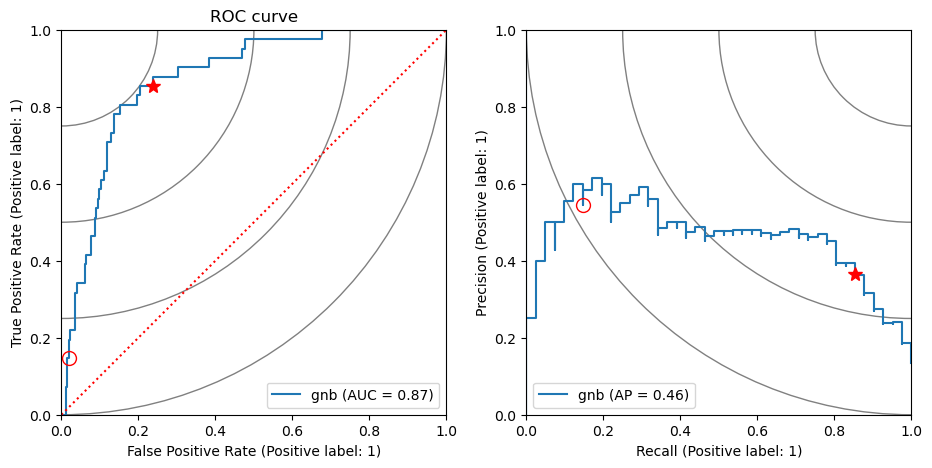

In [195]:
# фунция нахождения ближайшего индекса в упорядоченном списке
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
#######################################################
pos = 6# зададим порог (2) (21, 61)
point = find_nearest(thresholds,0.5) # найдем позицию порога вероятности 0.5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! звездочка
#######################################################
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((0, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((0, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((0, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((0, 1), 1, color='gray',fill=False)
ax1.add_patch(circle0)
ax1.add_patch(circle1)
ax1.add_patch(circle2)
ax1.add_patch(circle3)
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

precision, recall, thresholds_pr = precision_recall_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)  # найдем позицию порога вероятности 0.5
pos_pr = find_nearest(thresholds_pr,thresholds[pos]) # найдем позицию порога для thresholds в позиции pos

ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((1, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((1, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((1, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((1, 1), 1, color='gray',fill=False)
ax2.add_patch(circle0)
ax2.add_patch(circle1)
ax2.add_patch(circle2)
ax2.add_patch(circle3)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))

print( 'позиция порога 0.5 - ', point)
print( 'в позиции', pos, 'для ROC')
print( f'fpr:     {fpr[pos]:.3f}',       f' tpr:        {tpr[pos]:.3f}',          f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')


## Рассмотрение итоговой модели

In [87]:
pipe = Pipeline([
    ('preprocessing', MinMaxScaler()), 
    ('clf', LogisticRegression())
])

cv = StratifiedShuffleSplit(test_size=0.3, train_size=0.7, n_splits=4, random_state=42)
# score = make_scorer(precision_score, pos_label=1)

scaling = [MinMaxScaler(), StandardScaler(), RobustScaler()]

param_grid = [
    {'preprocessing': scaling,
     'clf__penalty': ['l2', 'l1'], 
     'clf__solver': ['saga', 'liblinear'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [6000],
     'clf__random_state': [42]},

    {'preprocessing': scaling,
     'clf__penalty': ['l2', None],  
     'clf__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [6000],
     'clf__random_state': [42]}
]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, scoring='roc_auc')#score)
grid.fit(X_train, y_train)

print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)  # вывод лучших результатов

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter 

Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.858227

Правильность для наилучшей модели на тестовом наборе: 0.886086



In [202]:
print("Лучшие параметры:", grid.best_params_)

Лучшие параметры: {'clf__class_weight': 'balanced', 'clf__max_iter': 6000, 'clf__penalty': 'l2', 'clf__random_state': 42, 'clf__solver': 'liblinear', 'preprocessing': RobustScaler()}


In [203]:
gnb = make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=6000, random_state=42))
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       264
           1       0.35      0.85      0.50        41

    accuracy                           0.77       305
   macro avg       0.66      0.81      0.68       305
weighted avg       0.89      0.77      0.80       305



позиция порога 0.5 -  38
в позиции 4 для ROC
fpr:     0.011  tpr:        0.220  thresholds:,0.934
recall:  0.220  precision:, 0.750  thresholds:,0.934


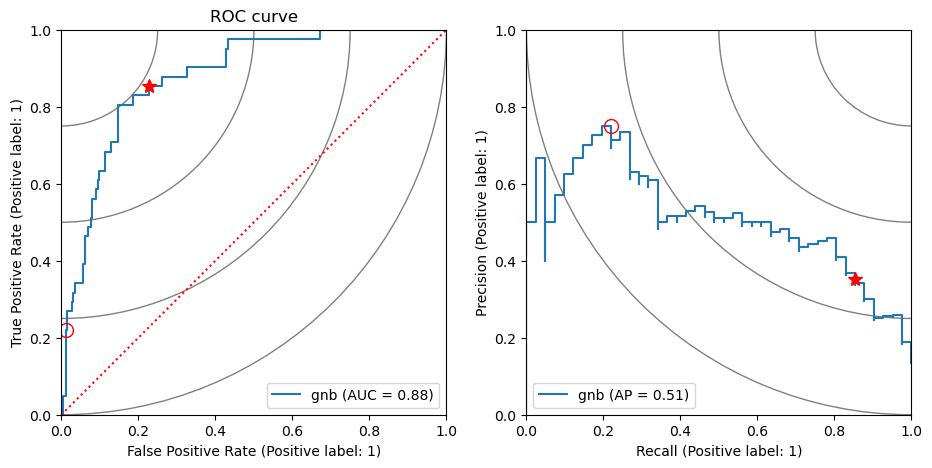

In [204]:
# фунция нахождения ближайшего индекса в упорядоченном списке
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

fpr, tpr, thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
#######################################################
pos = 4# зададим порог (2) (21, 61)
point = find_nearest(thresholds,0.5) # найдем позицию порога вероятности 0.5 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! звездочка
#######################################################
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((0, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((0, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((0, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((0, 1), 1, color='gray',fill=False)
ax1.add_patch(circle0)
ax1.add_patch(circle1)
ax1.add_patch(circle2)
ax1.add_patch(circle3)
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))

precision, recall, thresholds_pr = precision_recall_curve(y_test, gnb.predict_proba(X_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(gnb, X_test, y_test, name = 'gnb', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)  # найдем позицию порога вероятности 0.5
pos_pr = find_nearest(thresholds_pr,thresholds[pos]) # найдем позицию порога для thresholds в позиции pos

ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
circle0 = plt.Circle((1, 1), 0.25, color='gray',fill=False)
circle1 = plt.Circle((1, 1), 0.5, color='gray',fill=False)
circle2 = plt.Circle((1, 1), 0.75, color='gray',fill=False)
circle3 = plt.Circle((1, 1), 1, color='gray',fill=False)
ax2.add_patch(circle0)
ax2.add_patch(circle1)
ax2.add_patch(circle2)
ax2.add_patch(circle3)
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))

print( 'позиция порога 0.5 - ', point)
print( 'в позиции', pos, 'для ROC')
print( f'fpr:     {fpr[pos]:.3f}',       f' tpr:        {tpr[pos]:.3f}',          f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')
